In [23]:
# Import numerical and plotting libraries
import numpy as np
import matplotlib.pyplot as plt

# Import PyTorch and related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Import torchvision and related components
import torchvision as tv
from torchvision import transforms, datasets

# Ensure plots are displayed inline (if using Jupyter Notebook)
%matplotlib inline


In [24]:
# Create random data between (-10, 10) and determine ground truth
sim_in = 20 * torch.rand((1000, 1)) - 10
ground_truth = np.cos(sim_in)


In [25]:
# Calculate the number of parameters in a neural network
def calc_params(input_model):
    val = sum(params.numel() for params in input_model.parameters() if params.requires_grad)
    return val


In [26]:
class OptimizeNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc_1 = nn.Linear(1, 9)
        self.fc_2 = nn.Linear(9, 6)
        self.fc_3 = nn.Linear(6, 1)

    def forward(self, val):
        val = F.relu(self.fc_1(val))
        val = F.relu(self.fc_2(val))
        val = self.fc_3(val)
        return val


In [27]:
# Set up necessary auxiliaries for neural net training
optimize_net = OptimizeNN()
cost_func = nn.MSELoss()
optimizer = optim.Adam(optimize_net.parameters(), lr=0.001)


In [28]:
def min_ratio(weights):
    count = 0
    total = 0
    for weight in weights:
        if weight > 0:
            count += 1
        total += 1
    return count / total


In [29]:
def calculate_grad_norm(model):
    grad_norms = []
    for layer in model.modules():
        if isinstance(layer, nn.Linear):
            param_norm = layer.weight.grad.norm(2).item()
            grad_norms.append(param_norm)

    grad_mean = np.mean(grad_norms)  # compute mean of gradient norms
    return grad_mean


In [30]:
min_ratio_list = []
loss_list = []
train_count = 100
for i in range(train_count):
    epochs = 100
    total_loss = 0
    # Set up necessary auxiliaries for neural net training
    optimize_net = OptimizeNN()
    cost_func = nn.MSELoss()
    optimizer = optim.Adam(optimize_net.parameters(), lr=0.001)
    
    for epoch_index in range(epochs):
        optimize_net.zero_grad()
        output = optimize_net(sim_in)
        cost = cost_func(output, ground_truth)
        with torch.no_grad():
            total_loss += cost_func(output, ground_truth)
        cost.backward()
        optimizer.step()
    
    loss_list.append(total_loss / len(sim_in))
    num_params = calc_params(optimize_net)
    
    # Allocate Hessian size
    hessian = torch.zeros((num_params, num_params))

    y_hat = optimize_net(sim_in)
    y = sim_in
    loss = ((y_hat - y) ** 2).mean()
    
    # Calculate Jacobian w.r.t. model parameters
    jacobian = torch.autograd.grad(loss, list(optimize_net.parameters()), create_graph=True)
    jacobian = torch.cat([e.flatten() for e in jacobian])  # flatten

    # Fill in Hessian
    for i in range(num_params):
        result = torch.autograd.grad(jacobian[i], list(optimize_net.parameters()), retain_graph=True)
        hessian[i] = torch.cat([r.flatten() for r in result])  # flatten
    
    eigenvalues, _ = np.linalg.eig(hessian)
    min_ratio_list.append(min_ratio(eigenvalues))


In [31]:
num_params = calc_params(optimize_net)

In [32]:
hessian = torch.zeros((num_params, num_params))

y_hat = optimize_net(sim_in)
y = sim_in
loss = ((y_hat - y) ** 2).mean()

jacobian = torch.autograd.grad(loss, list(optimize_net.parameters()), create_graph=True)
jacobian = torch.cat([e.flatten() for e in jacobian])  # flatten

for i in range(num_params):
    result = torch.autograd.grad(jacobian[i], list(optimize_net.parameters()), retain_graph=True)
    hessian[i] = torch.cat([r.flatten() for r in result])  # flatten


Text(0, 0.5, 'Loss')

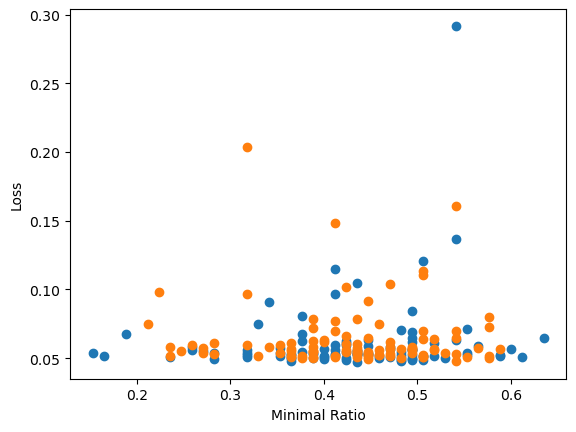

In [34]:
plt.scatter(minRatio, Loss)
plt.xlabel('Minimal Ratio')
plt.scatter(min_ratio_list, loss_list)
plt.xlabel('Minimal Ratio')
plt.ylabel('Loss')
plt.ylabel('Loss')